In [1]:
from slmfunctions.dependencies import *
from slmfunctions.settings import *
from slmfunctions.simulation import *
from slmfunctions.imageprocessing import *
from slmfunctions.phaseretrieval import *

## More dependencies
import scipy.fft as spfft
from scipy.ndimage import gaussian_filter1d as sp_gaussian_filter1d
from scipy.ndimage import affine_transform as sp_affine_transform
from scipy.ndimage import gaussian_filter as sp_gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product
 
cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    print("cupy not installed. Using numpy.")

# GLOBAL VARIABLES
numpixels = 1300
slmwidth = 1200
slmheight = 1920


Each pixel on the target tweezer array corresponds to: 0.2296875 microns
Airy disk radius is: 0.9107109375000002 microns
Tweezer spacing is: 2.0671874999999997 microns


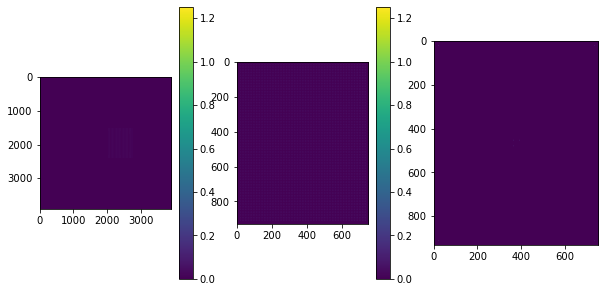

In [18]:
######### Optimized tweezer generator

### Settings
gpuoptimization = True
#Phase Offsets available: Off_None, Off_Rand, Off_Calc 
optimizedinitialguess = True # If this is true, then phase offset is on 
phaseoffset = Off_Rand
phaseoffsetoptimization = True
# #Phase optimizers available: Phase_MinJumps, Phase_MinAmp
phaseoffsetfunction = Phase_MinJumps
harmonicremoval = True
# #Cost Functions available: Pen_DeltaSqrt, Pen_Sqrt, Pen_Exp
gwscostfunction = Pen_DeltaSqrt
# #Error Metrics available: Err_MaxMinDiff, Err_Uniformity, Err_PowerEff
errormetric = Err_MaxMinDiff



sizefactor = 3
tweezerspacing = 9
numxtweezers = 80
numytweezers = 100
distancefromcenter = 72
centerwidth = 250
centerheight = 250
arraytype = "grid"
imgname = f"{numxtweezers}by{numytweezers}_{tweezerspacing}spacing_mag{sizefactor}" + arraytype # DEFINE NAME FIRST
tweezerarray = createtweezers_grid(cp.zeros((numpixels*sizefactor,numpixels*sizefactor)), tweezerspacing, numxtweezers, numytweezers, distancefromcenter )
# tweezerarray = createtweezers_withoutcenter(cp.zeros((numpixels*sizefactor,numpixels*sizefactor)), tweezerspacing, numxtweezers, numytweezers, centerwidth, centerheight)
# plt.imshow(zoomin(expand(tweezerarray,1)))
anchorimg = createanchors(tweezerarray, tweezerspacing, magnification = 1.5)

# For direct 250 mm lens imaging
pixelpitch = 8 * 10**(-6)# microns
focallength = 250 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

#For objectives imaging
pixelpitch = (8 * 200/250 * 10**(-6))# microns
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

fourierplanesize = wavelength * focallength / pixelpitch / (numpixels * sizefactor)
print(f"Each pixel on the target tweezer array corresponds to: {fourierplanesize*10**6} microns")

airydiskradius = 1.22 * wavelength * focallength / (pixelpitch*1200)
print(f"Airy disk radius is: {airydiskradius * 10**6} microns")
print(f"Tweezer spacing is: {tweezerspacing * fourierplanesize * 10**6} microns")

tweezerarray = tweezerarray/cp.max(tweezerarray)
weightedtweezers, diffraction = applydiffractionlimited(tweezerarray, fourierplanesize, pixelpitch, wavelength, focallength)
# tweezerarray = cp.array(gaussian_filter(tweezerarray.get(), airydiskradius / fourierplanesize /(2 * np.sqrt(2 * np.log(2)))))
# tweezerarray = cp.array(gaussian_filter(tweezerarray, 0.2))

tweezerarray = tweezerarray / cp.max(tweezerarray)
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
im1 = axs[0].imshow(weightedtweezers.get(), cmap='viridis')
im2 = axs[1].imshow(zoomin(weightedtweezers).get())
im3 = axs[2].imshow(zoomin(anchorimg).get())
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])

plt.show()


In [19]:
# Get the kvectors from the tweezer array]

kvector_tweezers = makeinitialkvectors(tweezerarray)
harmonics = identifyharmonics(kvector_tweezers, 0)
harmonics_coordinates = frequenciestopixels_harmonicsonly(harmonics, tweezerarray)
# Calculate offsets
kvector_initoffsets = Off_Calc(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
randomguess = cp.random.rand(1300, 1300)

In [20]:
# Get initial phase guess
initialphaseguess = create_phasemap(kvector_tweezers, kvector_initoffsets, wavetype=makesawtooth, opton=False, opttype=Phase_MinAmp, optiter=10)

In [ ]:
# Derive necessary phase for tweezers - fixed phase method
optimizedout_tweezer  = derivephase_fixed(Pen_Lukin, Pen_Lukin, tweezerarray, randomguess, 250, 20, uniformtarget=tweezerarray)

z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\slmfunctions\simulation.py:646: ComplexWarning: Casting complex values to real discards the imaginary part
  weightsnew[targetintensity > cutoff] = weights[targetintensity>cutoff]


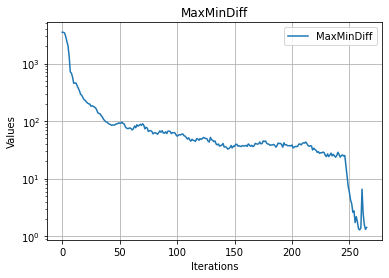

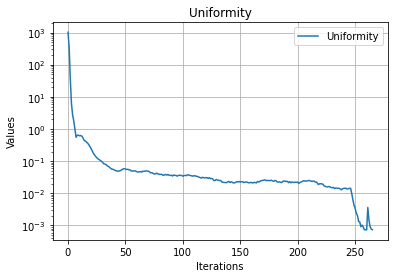

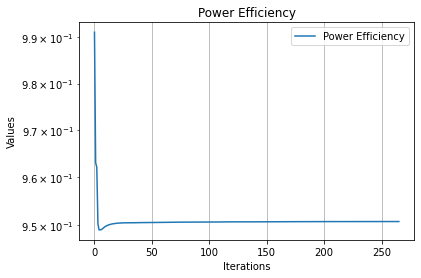

In [ ]:
errors_thing = optimizedout_tweezer.get_all_errors()
labels_thing = optimizedout_tweezer.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i].get(), label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

In [ ]:
optimizedout_anchors = derivephase_fixed(Pen_Lukin, Pen_Lukin, anchorimg, randomguess, 50, 10, uniformtarget = anchorimg)

z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\slmfunctions\simulation.py:646: ComplexWarning: Casting complex values to real discards the imaginary part
  weightsnew[targetintensity > cutoff] = weights[targetintensity>cutoff]


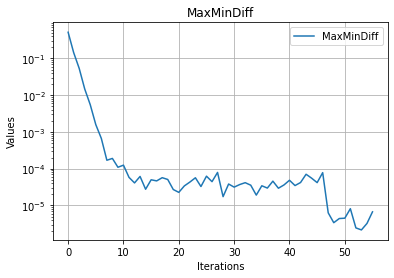

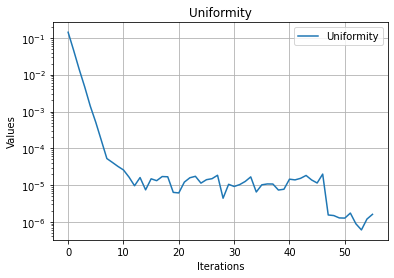

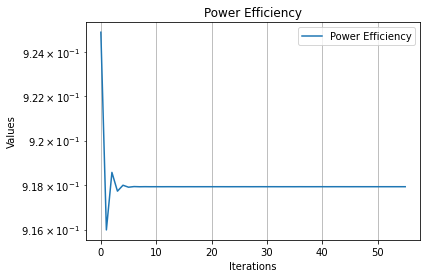

In [ ]:
errors_thing = optimizedout_anchors.get_all_errors()
labels_thing = optimizedout_anchors.get_all_labels()

for i, label in enumerate(labels_thing): 
    plt.figure()
    plt.plot(errors_thing[i].get(), label=label)
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()

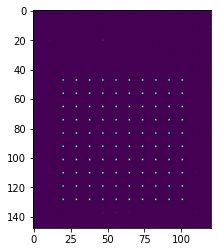

In [ ]:
plt.imshow(zoomin(removeleftside((optimizedout_tweezer.get_stdint())), 10000).get())

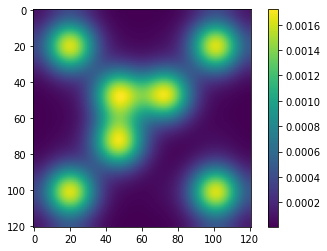

In [10]:
plt.imshow(gaussian_filter(zoomin(removeleftside(remove0thorder(optimizedout_anchors.get_stdint(),100),100), 1000000).get(),10))
plt.colorbar()

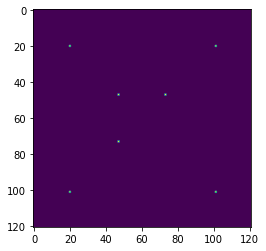

In [10]:
plt.imshow(zoomin(optimizedout_anchors.get_targetim()).get())

In [ ]:
# optimizedout_randguess  = derivephase(Pen_DeltaSqrt, tweezerarray, cp.random.rand(numpixels, numpixels), 100,1)
# kvector_initoffsets_none = Off_None(kvector_tweezers.get_magnitude(0), kvector_tweezers.get_angle(0), tweezerarray)
# initialphaseguess_nooffsets = create_phasemap(kvector_tweezers, kvector_initoffsets_none, wavetype=makesawtooth, opton=True, opttype=Phase_MinAmp, optiter=10)
# optimizedout_nooffsets  = derivephase(Pen_DeltaSqrt, tweezerarray, initialphaseguess_nooffsets, 1000,1)

In [11]:
# Convert to image files, and store!

save_dir = r'Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage'  # For PC
# save_dir = r'C:\cleen\nsong\2-Research\UAC Research\Github\Ultracold-Research\GWS_Summer2024\storage' # For laptop

save_to_file(optimizedout_tweezer, save_dir, f'tweezers{imgname}')
optimizedout_tweezer = load_from_file(save_dir, f'tweezers{imgname}')
save_to_file(optimizedout_anchors, save_dir, f'anchors{imgname}')
optimizedout_anchors = load_from_file(save_dir, f'anchors{imgname}')

Object saved to Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\tweezers10by10_9spacing_mag3grid.pkl
Object loaded from Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\tweezers10by10_9spacing_mag3grid.pkl
Object saved to Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\anchors10by10_9spacing_mag3grid.pkl
Object loaded from Z:\nsong\NeutralAtoms\Ultracold-Research\GWS_Summer2024\storage\anchors10by10_9spacing_mag3grid.pkl


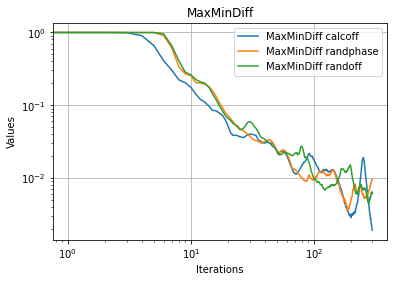

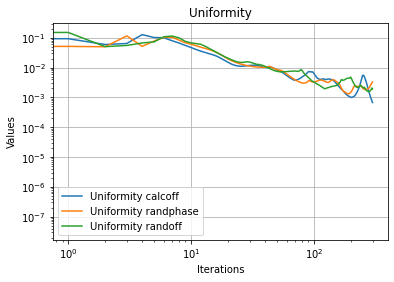

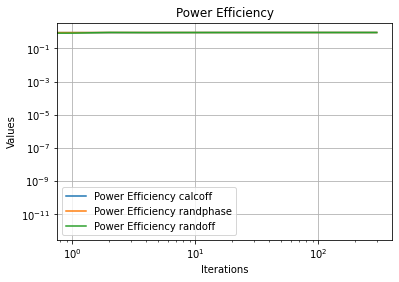

In [ ]:
errors = optimizedout.get_all_errors()
labels = optimizedout.get_all_labels()
errors_rand = optimizedout_randguess.get_all_errors()
labels_rand = optimizedout_randguess.get_all_labels()
errors_nooff = optimizedout_nooffsets.get_all_errors()
labels_nooff = optimizedout_nooffsets.get_all_labels()
for i, label in enumerate(labels):
    plt.figure()
    plt.loglog(errors[i].get(), label=str(cp.asnumpy(label))+" calcoff")
    plt.loglog(errors_rand[i].get(), label=str(cp.asnumpy(label))+" randphase")
    plt.loglog(errors_nooff[i].get(), label=str(cp.asnumpy(label))+" randoff")
    plt.title(label)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Values')
    plt.grid(True)
    plt.show()
